# Rigid body transformation in 2D

### Translation

\begin{equation*}
   X^\tau = f(B) = TX
\end{equation*}


DOF: 2

\begin{equation*}
    T = \begin{bmatrix}
    1 & 0 & t_x \\
    0 & 1 & t_y \\    
    0 & 0 & 1 \\
    \end{bmatrix}
\end{equation*}

### Rigid
DOF: 3

\begin{equation*}
    T = \begin{bmatrix}
    \cos(\theta) & -\sin(\theta) & t_x \\
    \sin(\theta) & \cos(\theta)  & t_y \\    
    0 & 0 & 1 \\
    \end{bmatrix}
\end{equation*}

### Similarity
DOF: 4
\begin{equation*}
    T = \begin{bmatrix}
    s\cos(\theta) & -s\sin(\theta) & t_x \\
    s\sin(\theta) & s\cos(\theta)  & t_y \\
    0 & 0 & 1 \\
    \end{bmatrix}
\end{equation*}

### Affine
DOF: 6
\begin{equation*}
    T = \begin{bmatrix}
    s_x\cos(\theta) & -s_{xy}\sin(\theta) & t_x \\
    s_{xy}\sin(\theta) & s_y\cos(\theta) & t_y \\    
    0 & 0 & 1 \\
    \end{bmatrix}
\end{equation*}

### Projective
DOF: 8
\begin{equation*}
    T = \begin{bmatrix}
    A & t \\
    v^T & v \\
    \end{bmatrix}
\end{equation*}


In [21]:
import numpy as np
# Translation
tx = 1
ty = 2
T = np.array([[1, 0, tx],[0, 1, ty],[0,0,1]], dtype=float)

# Rigid
tx = 1
ty = 2
theta = np.pi/10
T = np.array([[np.cos(theta), -np.sin(theta), tx],[np.sin(theta), np.cos(theta), ty],[0,0,1]], dtype=float)

# Similarity
tx = 1
ty = 2
theta = np.pi/10
s = 2
T = np.array([[s*np.cos(theta), -s*np.sin(theta), tx],[s*np.sin(theta), s*np.cos(theta), ty],[0,0,1]], dtype=float)

# Affine
tx = 1
ty = 2
theta = np.pi/10
sx = 2
sy = 1
sxy = 0.5
T = np.array([[sx*np.cos(theta), -sxy*np.sin(theta), tx],[sxy*np.sin(theta), sy*np.cos(theta), ty],[0,0,1]], dtype=float)

## Points based registration

### Procrustes problem

Point-based registration involves identifying corresponding three-dimensional points in the image to be aligned, registering the points and inferring the image transformation from the transformation determined from the points. Using notation ${x_A^i}_{i=1,...,N}$ in image $A$ and ${x_B^i}_{i=1,...,N}$ in image $B$ corresponding to the set of features ${x^i}_{i=1,...,N}$ in the object, and find the transformation that aligns them in a least square sense. The corresponding points are sometimes called homologous landmarks to emphasize that they should represent the same feature in the different images.

#### Solution
The classical Procrustes problem, i.e $T \in \{\text{rigid body transformations}\}$ has known solutions. A matrix representation of the rotational part can be computed using singular-value decomposition (SVD).

First replace $P$ and $Q$ by their demeaned versions, as the optimal transformation is form centroid the centroid

\begin{equation*}
    p_i \rightarrow  p_i - \bar{p}
\end{equation*}
\begin{equation*}
    q_i \rightarrow  q_i - \bar{q}
\end{equation*}

This reduces the problem to the orthogonal Procrustes problem in which we wish to determine the orthogonal rotation $R$. Central to the problem is the D-by-D correlation matrix $K:=P^tQ$, as this matrix quantifies how much the points in $Q$ are 'predicted' by points in $P$. If $P=[p_1^t,...,p_N^t]^t$ is a matrix of row vectors and the same for $Q$), $K=\sum_iK_i$ where $K_i:=p_iq_i^t$ then

\begin{equation*}
    K = UDV^t \Rightarrow R=V\Delta U^T  \text{ where } \Delta:=diag(1,1,det(VU^t)
\end{equation*}

where $K=UDV^t$ is the SVD of $K$.
It is essential for most medical registration application that $R$ does not include any reflections. This can be detected from the determinant of $VU^t$, which should be +1 for a rotation with no reflection, and will be -1 if there is a reflection. In the above equation, $\Delta$ takes this into account.

Finally the translation $t$ is given by $t = \bar{q} - R\bar{p}$

In [68]:
import numpy as np
# Points
P = np.array([[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7]])
Q = np.array([[1,0],[2,0],[3,0],[4,0],[5,0],[6,0],[7,0]])

# Demeaned version
pm = np.mean(P, axis=0)
qm = np.mean(Q, axis=0)
P = P - pm
Q = Q - qm

K = np.dot(P.T,Q)
U, D, Vt = np.linalg.svd(K, full_matrices=True)
det = np.linalg.det(np.dot(Vt.T, U.T))
grad = np.identity(2)
grad[1,1] = det

R = Vt.T.dot(grad).dot(U.T)
t = qm - np.dot(R,pm)
print("Rotation: {0}".format(R))
print("Translation: {0}".format(t))

Rotation: [[ 0.  1.]
 [-1.  0.]]
Translation: [0. 0.]


## Intensity based registration

Image registration using voxel similarity measure involves determining the transformation $\tau$ that relates the domain of image $A$ to image $B$. This transformation can then be usied to transform one image into the coordinates of the second within the region of overlap of the two domains $\Omega_{A,B}^T$. This process involves interpolation and needs to take account of the differences in sample spacing in image $A$ and $B$. Therefor using pixel index when dealing with image registration is never a good idea. Instead take image spacing and origin into account and use the actual pixel position.

In [69]:
class Image:
    def __init__(self, values, spacing, origin):
        self.Values = values
        self.Spacing = spacing
        self.Origin = origin

### Interpolation

The most widely used image interpolation function is probably trilinear - (for 3D) and bilinear interpolation (for 2D), in which a voxel value in the transformed coordinates is estimated by taking a weighted average of the nearest eight neighbours in the original dataset. The weightings, which add up to one, are inversely proportional to the distance of each neighbour to the new sample point.

#### Bilinear interpolation
Suppose that we want to find the value of the unknown function $f$ at the point $(x, y)$. It is assumed that we know the value of $f$ at the four points $Q_{11} = (x_1, y_1), Q_{12} = (x_1, y_2), Q_{21} = (x_2, y_1)$, and $Q_{22} = (x_2, y_2)$.

We first do linear interpolation in the x-direction. This yields

\begin{equation*}
    f(x,y_1) \approx \dfrac{x_2-x}{x_2-x_1}f(Q_{11}) + \dfrac{x-x_1}{x_2-x_1}f(Q_{21})
\end{equation*}
\begin{equation*}
    f(x,y_2) \approx \dfrac{x_2-x}{x_2-x_1}f(Q_{12}) + \dfrac{x-x_1}{x_2-x_1}f(Q_{22})
\end{equation*}

We proceed by interpolating in the y direction to obtain the desired estimate

\begin{equation*}
f(x,y) \approx \frac{y_2-y}{y_2-y_1} f(x, y_1) + \frac{y-y_1}{y_2-y_1} f(x, y_2) \\
= \frac{y_2-y}{y_2-y_1} \left ( \frac{x_2-x}{x_2-x_1} f(Q_{11}) + \frac{x-x_1}{x_2-x_1} f(Q_{21}) \right ) + \frac{y-y_1}{y_2-y_1} \left ( \frac{x_2-x}{x_2-x_1} f(Q_{12}) + \frac{x-x_1}{x_2-x_1} f(Q_{22}) \right ) \\
= \frac{1}{(x_2-x_1)(y_2-y_1)} \big( f(Q_{11})(x_2-x)(y_2-y) + f(Q_{21})(x-x_1)(y_2-y)+  f(Q_{12})(x_2-x)(y-y_1) + f(Q_{22})(x-x_1)(y-y_1) \big)\\
=\frac{1}{(x_2-x_1)(y_2-y_1)}  \begin{bmatrix} x_2-x & x-x_1 \end{bmatrix} \begin{bmatrix} f(Q_{11}) & f(Q_{12}) \\ f(Q_{21})& f(Q_{22}) \end{bmatrix} \begin{bmatrix}
y_2-y \\ y-y_1 \end{bmatrix}.
\end{equation*}

In [115]:
def BilinearInterpolate(x, y, I):
    """Bilinear interpolation of Image.
    Input:
        x - x position
        y - y position
        I - Image
    Output: 
        Interpolated intensity value I(x,y).
    """  
    i1 = math.floor((x - I.Origin[0] ) / I.Spacing[0])
    i2 = i1 + 1
    
    if(i2 >= I.Values.shape[0]): # Boundary check
        i2 = i1   
    
    x1 = i1 * I.Spacing[0] + I.Origin[0]
    x2 = i2 * I.Spacing[0] + I.Origin[0]
        
    j1 = math.floor((y - I.Origin[1] ) / I.Spacing[1])
    j2 = j1 + 1
    
    if(j2 >= I.Values.shape[1]): # Boundary check
        j2 = j1
    
    y1 = j1 * I.Spacing[1] + I.Origin[1]  
    y2 = j2 * I.Spacing[1] + I.Origin[1]  
    
    e = 1 / ((x2-x1)*(y2-y1) + 1e-5)
    X_diff = np.array([x2-x, x-x1], dtype=float, ndmin=2)
    fQ = np.array([[I.Values[i1,j1], I.Values[i1,j2]],[I.Values[i2,j1], I.Values[i2,j2]]], dtype=float, ndmin=2)    
    Y_diff = np.array([[y2-y],[y-y1]], dtype=float, ndmin=2)
    return e * X_diff.dot(fQ).dot(Y_diff)

### Transformation

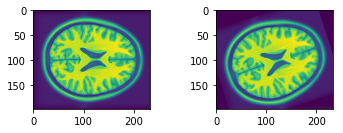

In [121]:
import math
def Transform(B, A, T, nullFill = True):
    """Transform image B into image A cordinate system using affine transformation matrix T.
    Input:
        A - Reference image of type Image
        B - Moving Image of type Image
        T - [3x3] Affine transformation matrix
    Output: 
        Image A' transformed into Bs cordinate system.
    """  
    invT = np.linalg.inv(T)
    
    if not nullFill:
        tImg = np.zeros(A.Values.shape, dtype=float) # TODO how should it be initilized
    else:    
        tImg = np.full(A.Values.shape, None, dtype=float) # TODO how should it be initilized    
    (minX, minY, maxX, maxY) = getExtremeValues(B)
    for i in range(tImg.shape[0]):
        for j in range(tImg.shape[1]):
            x = i * A.Spacing[0] + A.Origin[0]
            y = j * A.Spacing[1] + A.Origin[1]
            pos = np.dot(invT, np.array([x,y,1], dtype=float, copy=True))            
            if not (minX <= pos[0] <= maxX and minY <= pos[1] <= maxY): # Boundary check
                continue            
            val = BilinearInterpolate(pos[0], pos[1], B)
            tImg[i,j] = val
    return Image(tImg, A.Spacing, A.Origin)

# Load Data
t1_img = nib.load('mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_nlin_asym_09a/mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_fdata()
data = t1_data[:, :, 94]

origin = np.array([-data.shape[0]/2,-data.shape[1]/2])
spacing = np.array([1,1])
A = Image(data, spacing, origin)

## Transform data
theta_opt = np.pi/10
a_opt = np.cos(theta_opt)
b_opt = -np.sin(theta_opt)
tx_opt = 4
d_opt = np.sin(theta_opt)
e_opt = np.cos(theta_opt)
ty_opt = 0
T_opt = np.array([[a_opt, b_opt, tx_opt],[d_opt, e_opt, ty_opt],[0,0,1]], dtype=float)
b_spacing = np.array([1,1])
b_origin = np.array([-mi_data.shape[0]/2,-mi_data.shape[1]/2])
B = Transform(A, Image(np.zeros(data.shape), b_spacing, b_origin), T_opt, False)

# Plot data
ax = plt.subplot(2,2,1)
ax.imshow(A.Values)
ax = plt.subplot(2,2,2)
ax.imshow(B.Values)

## Cost Functions

### Sum of squared differences (SSD)
One of the simplest voxel similarity measures is the sum of squared differences between images, SSD, which is minimizied during registation. For $N$ voxels in the overlap domain $\Omega_{A,B}^T$

\begin{equation*}
    SSD = \dfrac{1}{N} \sum_{X_\Lambda \in \Omega_{A,B}^T} |A(x_A) + B^\tau(x_A)|^2
\end{equation*}

It is necessary to divide by the number of voxels $N$ in the overlap domain because $N=\sum_{\Omega_{A,B}^T} 1$ may vary with each estimate of $\tau$. The SSD measure is widely used for serial MR registrations.

In [117]:
def Residual(A, B):
    """Calculate the residual for the intensity values in image A and B on domain A
    Input:
        A - Reference image of type Image
        B - Moving Image of type Image
    Output: 
        an array with the residual values
    """
    residual = []
    for i in range(A.Values.shape[0]):
        for j in range(A.Values.shape[1]):
            if A.Values[i,j] != A.Values[i,j]: # Null check                
                continue                
            x = i * A.Spacing[0] + A.Origin[0]
            y = j * A.Spacing[1] + A.Origin[1]            
            f_r = BilinearInterpolate(x=x, y=y, I=B)
            residual.append(A.Values[i,j] - f_r)
    return np.array([residual], dtype=float).T

def SSD_cost(residual):
    """Calculate the sum of squared differences (SSD) between intensity values of image A and B
    Input:
        residual - the residual in every point of the given domain (Ai - Bi)
    Output: 
        the cost
    """
    return np.sum(residual**2)/residual.size

r = Residual(A,B)
cost = SSD_cost(r)
print(cost)

383.6326807380542


### Sum of absolute differences (SAD)

The SSD measure is very sensitive to a small number of voxels that have large intensity differences between image $A$ and $B$. This might arise, for example, in contrast material is injected into the patient between the acquisition of image $A$ and $B$ or if the images are acquired during an intervention and instrumetns are in different position relative to the subject in the two acquisitions. The effect of these 'outlier' voxels can be reduced by using the sum of absolute differences, SAD radther than SSD:

\begin{equation*}
    SAD = \dfrac{1}{N} \sum_{X_\Lambda \in \Omega_{A,B}^T} |A(x_A) + B^\tau(x_A)|
\end{equation*}

In [119]:
def SAD_cost(residual):
    """Calculate the sum of absolute differences (SAD) between intensity values of image A and B
    Input:
        residual - the residual in every point of the given domain (Ai - Bi)
    Output: 
        the cost
    """
    return np.sum(np.abs(residual))/residual.size

r = Residual(A,B)
cost = SAD_cost(r)
print(cost)

12.707849643692251


## Optimization


In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import ImageRegistration as ir
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

(197, 233)


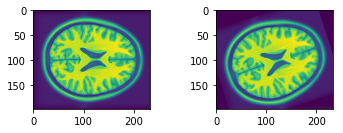

In [3]:
# 1 Define images
## Moving Image
t1_img = nib.load('mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_nlin_asym_09a/mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_fdata()
mi_data = t1_data[:, :, 94]
print(mi_data.shape)
mi_origin = np.array([-mi_data.shape[0]/2,-mi_data.shape[1]/2])
mi_spacing = np.array([1,1])
mi_org = ir.Image(mi_data, mi_spacing, mi_origin)

## Create ReferenceImage
theta_opt = np.pi/10
a_opt = np.cos(theta_opt)
b_opt = -np.sin(theta_opt)
tx_opt = 4
d_opt = np.sin(theta_opt)
e_opt = np.cos(theta_opt)
ty_opt = 0
T_opt = np.array([[a_opt, b_opt, tx_opt],[d_opt, e_opt, ty_opt],[0,0,1]], dtype=float)
r_spacing = np.array([1,1])
r_origin = np.array([-mi_data.shape[0]/2,-mi_data.shape[1]/2])
r_org = ir.Transform(mi_org, ir.Image(np.zeros(mi_data.shape), r_spacing, r_origin), T_opt, False)
ax = plt.subplot(2,2,1)
ax.imshow(mi_org.Values)

ax = plt.subplot(2,2,2)
ax.imshow(r_org.Values)

In [72]:
# Initial guess T
mi = ir.Image(values=np.copy(mi_org.Values), spacing=mi_org.Spacing, origin= mi_org.Origin)
mi.Values = (mi.Values - np.mean(mi.Values))

r = ir.Image(values=np.copy(r_org.Values), spacing=r_org.Spacing, origin= r_org.Origin)
r.Values = (r.Values - np.mean(r.Values))

theta = 0
a = np.cos(theta)
b = -np.sin(theta)
c = np.cos(theta)
tx = 0
ty = 0
T = np.array([[a, b, tx],[-b, a, ty],[0,0,1]], dtype=float)
alphaR = 1e-5
alphaT = 1e-2
for e in range(3000):    
    dA = 0
    dB = 0
    dC = 0
    dTx = 0
    dTy = 0
    dTheta = 0    
    Xprim = ir.Transform(mi, r, T)    
    diff = (Xprim.Values.T - r.Values.T)
    m = diff.size
    cost = 1/m * np.sum((diff)**2)
    print("e: {0} cost: {1}".format(e, cost))
    for i in range(m):        
        dA = dA + 2 * (U[i,0] * (Xprim[i,0] - X[i,0]))
        dB = dA + 2 * (U[i,1] * (Xprim[i,0] - X[i,0]) - U[i,0] * (Xprim[i,1] - X[i,1]))
        dC = dC + 2 * (U[i,1] * (Xprim[i,1] - X[i,1]))
        dTx = dTx + 2 * ((Xprim[i,0] - X[i,0]))
        dTy = dTy + 2 * ((Xprim[i,1] - X[i,1]))
    at = a
    a = at - alphaR * dA    
    bt = b
    b = bt - alphaR * dB    
    ct = c
    c = ct - alphaR * dC    
    txt = tx
    tx = txt - alphaT * dTx    
    tyt = ty
    ty = tyt - alphaT * dTy
    print("tx(t+1): {0} tx(t): {1} dTx: {2}".format(tx, txt, dTx))
    print("ty(t+1): {0} ty(t): {1} dTy: {2}".format(ty, tyt, dTy))
    if False:
        print("a(t+1): {0} a(t): {1} dA: {2}".format(a, at, dA))
        print("b(t+1): {0} b(t): {1} dB: {2}".format(b, bt, dB))    
        print("c(t+1): {0} c(t): {1} dC: {2}".format(c, ct, dC))
        
    T = np.array([[a, b, tx],[-b, a, ty],[0,0,1]], dtype=float)   
    
print(T)
print(np.cos(theta_opt))
print(tx_opt)
print(ty_opt)
TImage = ir.Transform(image = mi, refImg= r, T=T,nullFill=False)

ax = plt.subplot(2,2,1)
ax.imshow(TImage.Values)

ax = plt.subplot(2,2,2)
ax.imshow(r_org.Values)

e: 0 cost: 383.24426717658656


TypeError: 'Image' object is not subscriptable

nan

In [74]:
# Intensity based with Gauss Newton
def CalculateCost(residual):
    return np.sum(residual**2)/residual.size

def GetResidual(m,r,T):
    residual = []       
    for i in range(m.Values.shape[0]):
        for j in range(m.Values.shape[1]):
            if m.Values[i,j] != m.Values[i,j]: # Null check                
                continue                
            x = i * m.Spacing[0] + m.Origin[0]
            y = j * m.Spacing[1] + m.Origin[1]            
            f_r = ir.BilinearInterpolate(x=x, y=y, image=r)         
            residual.append(m.Values[i,j] - f_r)
    return np.array([residual], dtype=float).T

def GetJacobian(m, P):
    a = P[0,0]
    b = P[1,0]
    c = P[2,0]
    tx = P[3,0]
    ty = P[4,0]
    T = np.array([[a, b, tx],[-b, c, ty],[0,0,1]], dtype=float)
    h = 1e-4
    J = []    
    for i in range(m.Values.shape[0]):
        for j in range(m.Values.shape[1]):
            if m.Values[i,j] != m.Values[i,j]: # Null check                
                continue                
            x = i * m.Spacing[0] + m.Origin[0]
            y = j * m.Spacing[1] + m.Origin[1]            
            U = np.linalg.solve(T, np.array([[x,y,1]], dtype=float).T)
            u = U[0,0]
            v = U[1,0]            
            f_mxh1 = ir.BilinearInterpolate(x=x+h, y=y, image=m)
            f_mxh2 = ir.BilinearInterpolate(x=x-h, y=y, image=m)
            f_myh1 = ir.BilinearInterpolate(x=x, y=y+h, image=m)
            f_myh2 = ir.BilinearInterpolate(x=x, y=y-h, image=m)
            dfx = (f_mxh1 - f_mxh2)/(2*h)
            dfy = (f_myh1 - f_myh2)/(2*h)
            
            # 5 parameters            
            dA = u*dfx
            dB = -u*dfx + v*dfy
            dC = v*dfx
            dtx = dfx
            dty = dfy
            j = [dA, dB, dC, dtx, dty]
                        
            J.append(j)
    return np.array(J, dtype=float)

theta = 0
a = np.cos(theta)
b = -np.sin(theta)
c = np.cos(theta)
tx = 0
ty = 0
P = np.array([[a, b, c, tx, ty]], dtype=float).T

mi = ir.Image(values=np.copy(mi_org.Values), spacing=mi_org.Spacing, origin= mi_org.Origin)
mi.Values = (mi.Values - np.mean(mi.Values))

r = ir.Image(values=np.copy(r_org.Values), spacing=r_org.Spacing, origin= r_org.Origin)
r.Values = (r.Values - np.mean(r.Values))
alpha = np.array([[1],[1],[1],[1],[1]])
for i in range(10):
    T = np.array([[P[0,0], P[1,0], P[3,0]]
                ,[-P[1,0], P[2,0], P[4,0]]
                ,[0,0,1]], dtype=float)
    mo = Transform(image=mi, refImg=r, T=T, nullFill=True)    
    residual = GetResidual(mo, r, T)
    cost = CalculateCost(residual)
    J = GetJacobian(mo, P)
    P = P + alpha * np.linalg.solve(np.dot(J.T, J), np.dot(J.T,residual))
    print("Episode: {0}, Cost: {1}".format(i, cost))
    print("P: {0}".format(P.T))

#print(residual)
#print(cost)
ax = plt.subplot(2,3,1)
ax.imshow(mi.Values)

ax = plt.subplot(2,3,2)
ax.imshow(mo.Values)

ax = plt.subplot(2,3,3)
ax.imshow(r.Values)

TypeError: Transform() got an unexpected keyword argument 'image'

ImportError: No module named 'cv2'